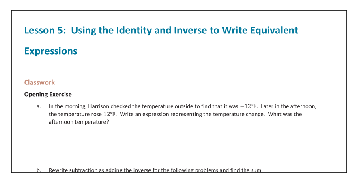

In [1]:
from wand.image import Image
from IPython.utils import io

lesson = 'Algebra1-m03-b-l08'
lesson = 'g07-m03-a-l05'
raw = cv2.imread('../data/EngageNY/%s.png' % lesson);

# the following with... statement is a way to keep matplotlib commands from chattering output
# (from https://stackoverflow.com/questions/23692950/how-do-you-suppress-output-in-ipython-notebook)
with io.capture_output() as captured:
    # just render the top 400 pixel-rows of the image
    plt.imshow(cv2.cvtColor(raw[0:400,:], cv2.COLOR_BGR2RGB))
    plt.xticks([])
    plt.yticks([])
 
plt.show()

(1662, 206, 3)
(1662, 206)


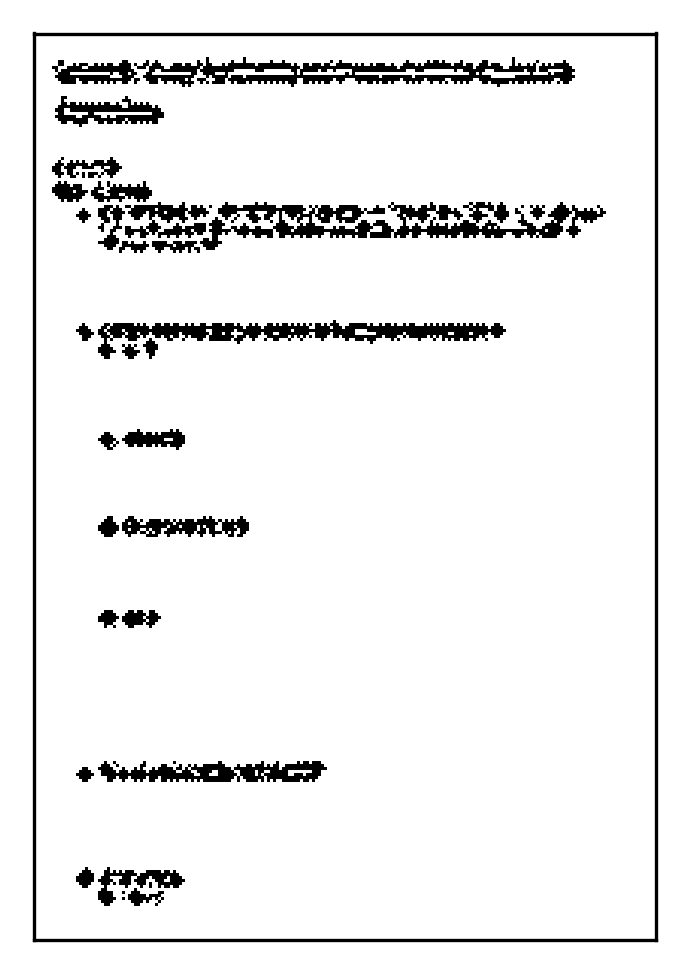

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import modules.pdfutil as pdfutil

mpl.rcParams['figure.dpi']= 300 # sets a target resolution for the rendering of the image figure

downsampled = cv2.resize(raw, None, fx=0.25,fy=0.25)
print(downsampled.shape)
gray = cv2.cvtColor(downsampled, cv2.COLOR_BGR2GRAY)
# gray = np.uint8(gray16 / 256)
    
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))

ext = cv2.erode(gray, kernel, iterations=2)
    
thresh = cv2.adaptiveThreshold(ext, 1, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 5, 10)
print(thresh.shape)

with io.capture_output() as captured:
    # just render the top 300 pixel-rows of the grayscale+threshold image
    plt.imshow(thresh[0:300,:], cmap='gray' , interpolation='none')
    plt.xticks([])
    plt.yticks([])
    
plt.show()

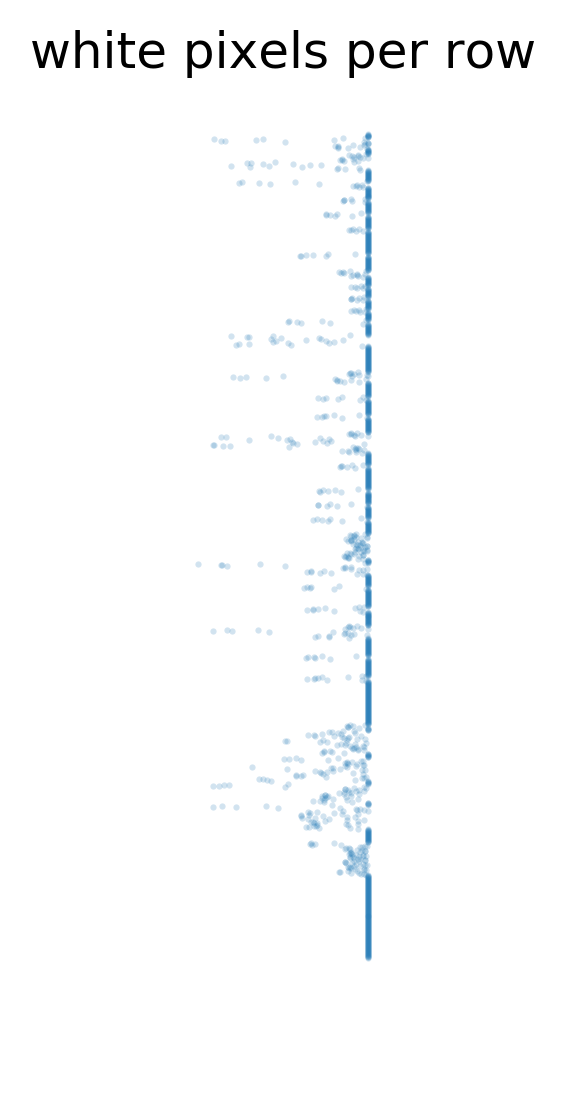

In [3]:
#count the number of (thresholded-to) white pixels in each row
row_counts = cv2.reduce(thresh, 1, cv2.REDUCE_SUM, dtype=cv2.CV_32SC1).flatten()

#plot the white pixel counts
with io.capture_output() as captured:
    plt.scatter(row_counts, range(0,len(row_counts)), marker='.', alpha=0.2, s=1)
    plt.gca().set_aspect(0.5)
    plt.gca().invert_yaxis()
    plt.gca().axis('off')
    plt.title('white pixels per row')
    
plt.show()

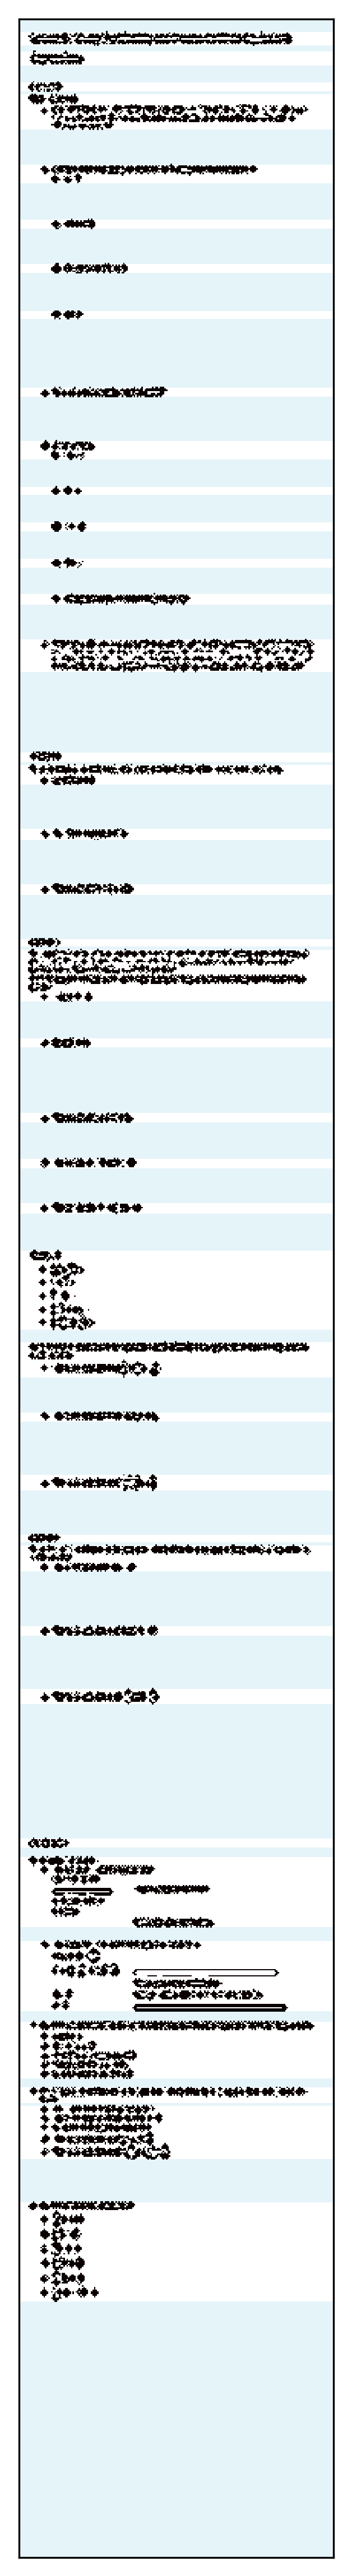

In [4]:
from itertools import groupby
from statistics import median
import matplotlib.patches as patches

height,width = gray.shape;

# white_rows is a binary vector of length height. white_rows[i]=1 if and only if the i'th row
# in the thresholded image is all white pixels
white_rows = np.where(row_counts==max(row_counts), 1, 0)

# from white_rows we build the array white_blocks that contains arrays of the form [start,end]
# with the start and end rows of all-white blocks of rows... i.e. bound on vertical whitespace
white_blocks = []
pos = 0
for k,g in groupby(white_rows):
   start = pos-1
   end = pos + len(list(g))
   is_margin = start==0 or end==height
   is_margin = False
   if k==1 and not is_margin: 
       white_blocks.append([start,end-1])
   pos = end

median_size = median([b[1]-b[0] for b in white_blocks])

min_block_size = max(median_size//5, 5)
min_block_size = 0

# throw out small blocks of whitespace
white_blocks = [b for b in white_blocks if (b[1]-b[0]>=min_block_size)]

# alternate array of only above-median height blocks of whitespace
big_blocks = [b for b in white_blocks if (b[1]-b[0]>=median_size)]

only_big = (len(white_blocks) > 5)
blocks = big_blocks if only_big else white_blocks
blocks = white_blocks

# place segmentation breaks within the selected whitespace blocks... near the bottom of each
breaks = [b[1] - min(median_size//5, (b[1]-b[0])//2)  for b in blocks]

# render an image showing what the algorithm did:
fig1 = plt.figure(figsize = (8.5,20))
ax = fig1.add_subplot(1,1,1)

with io.capture_output() as captured:
    ax.imshow(thresh, cmap='hot')
    ax.set_xticks([])
    ax.set_yticks([])

    #highlight the detected vertical whitespace blocks in light blue
    for b in blocks:
        rect = patches.Rectangle((0,b[0]),width, b[1]-b[0]+1,linewidth=1,
                                 edgecolor='none',facecolor=(0.0,0.6,0.8,0.1))
        ax.add_patch(rect)

    #highlight the cut lines in red:
    for b in breaks:
        rect = patches.Rectangle((0,b),width, 0,linewidth=0.25,edgecolor='r',facecolor='none')
        # ax.add_patch(rect)




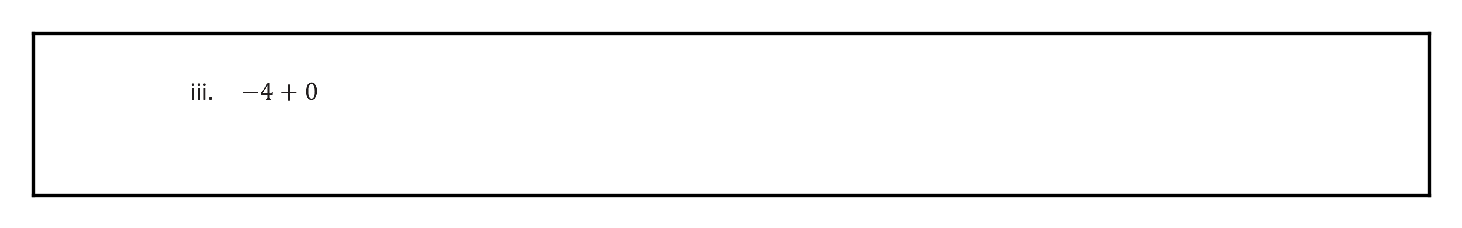

In [5]:
# using the segmentation cut lines, take a bunch of subimages from the original (raw) image array
subimage_bounds = []
pos = 0
for b in breaks:
    subimage_bounds.append([pos, b])
    pos = b
subimage_bounds.append([pos,height])

raw_hr = cv2.imread('../data/EngageNY/%s-hi-res.png' % lesson);

# the subimages array will contain an array of len(breaks)+1 non-overlapping images taken from raw[]
# (the raw image was downsampled by 4x in the processing that found the cut lines, 
# and raw_hr has 3x the resolution of raw, hence the 3*4* below.)
subimages = [ [ raw[4*int(b[0]):4*int(b[1])-1], raw_hr[4*4*int(b[0]):4*4*int(b[1])-1]] for b in subimage_bounds ]

sel_img = subimages[12][1]
with io.capture_output() as captured:
    plt.imshow(cv2.cvtColor(sel_img, cv2.COLOR_BGR2RGB))
    plt.xticks([])
    plt.yticks([])
 
plt.show()


In [6]:
import pytesseract as tess
import pandas
import IPython

txt = tess.image_to_string(sel_img, lang='eng') ;
data = tess.image_to_data(sel_img, lang='eng', config="--psm 11 --oem 1")
eng_data = pandas.read_csv(io.StringIO(data), sep="\t") ;
lines = txt.split('\n')
sentences = [l.split('. ') for l in lines]
lines

with IPython.utils.io.capture_output() as captured:
    fig, ax = plt.subplots()
    ax.imshow(sel_img)
    li = 0
    for index, row in eng_data.iterrows():
        if (row.level==2): 
            li = li+1
        if (li!=4):
            continue
        if row.level>1:
            pad = 2
            alpha = 0.4
            color = 'green' if row.conf>=95 else ('orange' if row.conf>80 else 'red')
            if row.level<5:
                color = "black"
                pad = 8
                alpha = 0.2
            if row.level==5 or row.level==2:
                rect = patches.Rectangle((row.left-pad,row.top-pad), row.width+2*pad, row.height+2*pad,
                                         fill=False, edgecolor=color, alpha=alpha, linewidth=0.5)
                ax.add_patch(rect)

    ax.set_axis_off()
    plt.tight_layout()
plt.show()

eng_data

AttributeError: module 'IPython.utils.io' has no attribute 'StringIO'

In [ ]:
from skimage.segmentation import felzenszwalb
from scipy.ndimage import label
FZ = felzenszwalb(sel_img) # felzenszwalb
labeled_segmentsFZ, _ = label(FZ) # label the segments

with io.capture_output() as captured:
    plt.figure()
    plt.imshow(labeled_segmentsFZ)
    plt.gca().axis('off')
plt.show()

In [ ]:
from skimage.measure import regionprops

subimages = []
with io.capture_output() as captured:
    fig, ax = plt.subplots()
    ax.imshow(sel_img)
    for region in regionprops(labeled_segmentsFZ):
        # if region.area >= 1:
        y0, x0, y1, x1 = region.bbox
        rect = patches.Rectangle((x0,y0), x1-x0, y1-y0,fill=False, edgecolor='red', linewidth=0.5)
        ax.add_patch(rect)
        subimages.append(sel_img[y0:y1,x0:x1])

    ax.set_axis_off()
    plt.tight_layout()
plt.show()


In [ ]:
import pytesseract as tess
from io import StringIO
import pandas

txt = tess.image_to_string(sel_img, lang='eng')
boxes = tess.image_to_boxes(sel_img, lang='eng').split('\n')

data = tess.image_to_data(sel_img, lang='eng')
eng_data = pandas.read_csv(StringIO(data), sep="\t")


lines = txt.split('\n')
sentences = [l.split('. ') for l in lines]

# txt,boxes,sentences,data
# equ_data
#eng_data

tess.image_to_string(sel_img, lang='eng', config="--psm 11 --oem 1")

eng_data


In [ ]:
import io
import tesserocr

from PIL import Image
im = Image.fromarray(sel_img)
    
tesserocr.image_to_text(im)

with tesserocr.PyTessBaseAPI() as api:
    api.SetImage(im)
    api.Recognize()
    iterator = api.GetIterator()
    level = tesserocr.RIL.SYMBOL
    #for r in tesserocr.iterate_level(iterator, level):
        #symbol = r.GetUTF8Text(level)  # r == ri
        #conf = r.Confidence(level)
        #if symbol:
        #    print('symbol {}, conf: {}'.format(symbol, conf))
        #indent = False
        #ci = r.GetChoiceIterator()
        #for c in ci:
        #    if indent:
        #        print('\t\t ')
        #    print('\t- ')
        #    choice = c.GetUTF8Text()  # c == ci
        #    print (u'{} conf: {}'.format(choice, c.Confidence()))
        #    indent = True
        #print('---------------------------------------------')
    #print(iterator.WordFontAttributes())
    #f = iterator.WordFontAttributes()
    #iterator.next()
    #iterator.WordFontAttributes()

#f


In [ ]:
ssi = subimages[1]
with io.capture_output() as captured:
    plt.imshow(cv2.cvtColor(ssi, cv2.COLOR_BGR2RGB))
    plt.xticks([])
    plt.yticks([])
 
plt.show()

In [ ]:
import pytesseract

for ssi in subimages:
    with io.capture_output() as captured:
        plt.imshow(cv2.cvtColor(ssi, cv2.COLOR_BGR2RGB))
        plt.xticks([])
        plt.yticks([])

    plt.show()
    pytesseract.image_to_string(ssi)